In [2]:
import sys
import os
import spams
import numpy as np
import math
from sklearn import preprocessing
from multiprocessing import Pool
from functools import partial
import signal

from PIL import Image
Image.MAX_IMAGE_PIXELS = None

import warnings
warnings.simplefilter('ignore', Image.DecompressionBombWarning)


import glob
import sys


import pandas as pd


import numpy as np
import time
import cv2
import openslide
import pyvips
from PIL import Image
Image.MAX_IMAGE_PIXELS = None

import tensorflow as tf
#tf.logging.set_verbosity(tf.logging.ERROR)
tf.get_logger().setLevel(tf.compat.v1.logging.ERROR)
import matplotlib.pyplot as plt

In [3]:
filename = "/drive3/Anshuman/testing_project/vahadane/81_241.png"

level=0
I= openslide.open_slide(filename)

In [4]:
xdim,ydim=I.level_dimensions[level]

xdim,ydim

(256, 256)

In [5]:
img=np.asarray(I.read_region((0,0),level,(256,256)))[:,:,:3]
img

array([[[192, 138, 215],
        [212, 169, 225],
        [229, 198, 232],
        ...,
        [228,  90, 185],
        [228,  93, 190],
        [213,  81, 184]],

       [[209, 160, 225],
        [218, 178, 224],
        [241, 209, 241],
        ...,
        [244, 102, 196],
        [235,  94, 192],
        [217,  79, 183]],

       [[218, 163, 228],
        [227, 180, 231],
        [232, 189, 234],
        ...,
        [248, 107, 199],
        [239,  99, 194],
        [220,  82, 185]],

       ...,

       [[157,  77, 121],
        [141,  60, 107],
        [162,  84, 133],
        ...,
        [219, 131, 212],
        [227, 134, 214],
        [231, 132, 213]],

       [[177,  87, 129],
        [202, 112, 156],
        [210, 119, 169],
        ...,
        [231, 140, 214],
        [234, 141, 216],
        [237, 141, 218]],

       [[163,  64, 115],
        [205, 106, 160],
        [213, 113, 172],
        ...,
        [232, 148, 219],
        [232, 150, 223],
        [233, 149, 225]]

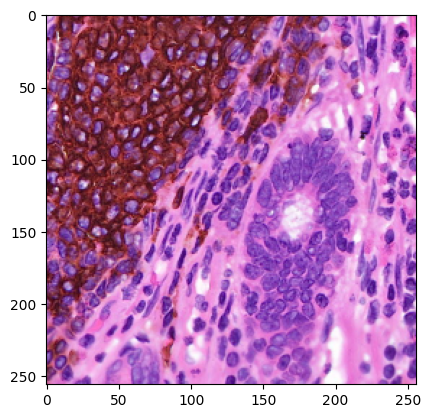

In [6]:
plt.imshow(img)

In [7]:
s=img.shape
if len(s)==2:
    third_dim=1
else:
    third_dim=s[2] 

In [8]:
third_dim

3

In [9]:
Ivecd = np.reshape(img, (s[0]*s[1],third_dim))
print(Ivecd.shape)

(65536, 3)


In [10]:
i0 = np.array([255.0,255.0,255.0])


V=np.log(i0)- np.log(Ivecd+1.0)

In [11]:
w_threshold=220
c = (Ivecd[:,0]<w_threshold) * (Ivecd[:,1]<w_threshold) * (Ivecd[:,2]<w_threshold)
Ivecd=Ivecd[c]
print(Ivecd.shape)

(45335, 3)


In [12]:
VforW=np.log(i0)- np.log(Ivecd+1.0)

In [13]:
def definePar(nstains,lamb,batch=None):

	param={}	
	#param['mode']=2               #solves for =min_{D in C} (1/n) sum_{i=1}^n (1/2)||x_i-Dalpha_i||_2^2 + ... 
								   #lambda||alpha_i||_1 + lambda_2||alpha_i||_2^2
	param['lambda1']=lamb
	#param['lambda2']=0.05
	param['posAlpha']=True         #positive stains 
	param['posD']=True             #positive staining matrix
	param['modeD']=0               #{W in Real^{m x n}  s.t.  for all j,  ||d_j||_2^2 <= 1 }
	param['whiten']=False          #Do not whiten the data                      
	param['K']=nstains             #No. of stain = 2
	param['numThreads']=-1         #number of threads
	param['iter']=100               #20-50 is OK
	param['clean']=True
	if batch is not None:
		param['batchsize']=batch   #Give here input image no of pixels for traditional dictionary learning
	return param

In [14]:
param=definePar(3,0.01)

In [15]:
Ws = spams.trainDL(np.asfortranarray(np.transpose(VforW)),**param)
Ws

num param iterD: 1
Online Dictionary Learning with no parameter 
Positivity constraints on D activated
Positivity constraints on alpha activated
mode Alpha 2
Cleaning activated 
batch size: 6400
L: 3
lambda: 0.01
mode: 2
*****Online Dictionary Learning*****
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24
Iteration: 25
Iteration: 26
Iteration: 27
Iteration: 28
Iteration: 29
Iteration: 30
Iteration: 31
Iteration: 32
Iteration: 33
Iteration: 34
Iteration: 35
Iteration: 36
Iteration: 37
Iteration: 38
Iteration: 39
Iteration: 40
Iteration: 41
Iteration: 42
Iteration: 43
Iteration: 44
Iteration: 45
Iteration: 46
Iteration: 47
Iteration: 48
Iteration: 49
Iteration: 50
Iteration: 51
Iteration: 52
Iteration:

Time elapsed : 0.169802


array([[0.25063209, 0.2108114 , 0.60191236],
       [0.66894117, 0.95985471, 0.76516517],
       [0.69978658, 0.18503374, 0.22852524]])

In [16]:
Ws

array([[0.25063209, 0.2108114 , 0.60191236],
       [0.66894117, 0.95985471, 0.76516517],
       [0.69978658, 0.18503374, 0.22852524]])

In [17]:
Hiv=np.transpose(np.dot(np.linalg.pinv(Ws),np.transpose(V)))
Hiv[Hiv<0]=0
print(Hiv.shape)
Hiv

(65536, 3)


array([[0.03967132, 0.34509916, 0.3254288 ],
       [0.04639813, 0.23187502, 0.19846847],
       [0.06043192, 0.13820194, 0.09786061],
       ...,
       [0.08929803, 0.56562524, 0.        ],
       [0.06029338, 0.56104013, 0.        ],
       [0.04379635, 0.58686621, 0.        ]])

In [18]:
Whe = np.delete(Ws,0,axis=1)
print(Whe)
y =Whe.T
print(y.shape)
y

[[0.2108114  0.60191236]
 [0.95985471 0.76516517]
 [0.18503374 0.22852524]]
(2, 3)


array([[0.2108114 , 0.95985471, 0.18503374],
       [0.60191236, 0.76516517, 0.22852524]])

In [19]:
Hhe = np.delete(Hiv,0,axis=1)
print(Hhe.shape)
Hhe
x = Hhe
print(x.shape)
x

(65536, 2)
(65536, 2)


array([[0.34509916, 0.3254288 ],
       [0.23187502, 0.19846847],
       [0.13820194, 0.09786061],
       ...,
       [0.56562524, 0.        ],
       [0.56104013, 0.        ],
       [0.58686621, 0.        ]])

In [20]:
i0

array([255., 255., 255.])

In [21]:
vdummy =np.matmul(x,y)
print(vdummy.shape)
vdummy2 = np.exp(-vdummy)
vdummy3 =i0*np.reshape(vdummy2,(256,256,3))
print(vdummy3.shape)
vdummy3

(65536, 3)
(256, 256, 3)


array([[[194.92855254, 142.7381326 , 222.0804855 ],
        [215.4914054 , 175.35913272, 233.45837358],
        [233.51013673, 207.20947261, 243.06475827],
        ...,
        [199.51174271,  83.42645009, 205.58899711],
        [200.65242443,  85.62037374, 206.6203356 ],
        [197.53540749,  79.72934591, 203.80039892]],

       [[211.4060834 , 163.89329295, 230.25041697],
        [223.32583716, 188.5931615 , 237.62979532],
        [243.443937  , 213.36096027, 246.05318611],
        ...,
        [200.82114884,  85.94867368, 206.7728255 ],
        [198.84362165,  82.16195312, 204.98458601],
        [194.84688662,  74.90662766, 201.36374739]],

       [[220.21113226, 166.43189435, 232.55354465],
        [230.25014181, 185.8070073 , 238.44949187],
        [235.14632244, 194.70734956, 241.09416863],
        ...,
        [202.27691652,  88.82226327, 208.08787147],
        [200.68899025,  85.69143944, 206.65338442],
        [195.90308174,  76.77328162, 202.32148194]],

       ...,

      

In [22]:
cv2.imwrite("combinedstainedw0h0.png", cv2.cvtColor((vdummy3).astype(np.uint8), cv2.COLOR_RGB2BGR))

True